In [1]:
!pip install duckdb --no-index --find-links=file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg

Looking in links: file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
Processing /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg/duckdb-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import polars as pl
import duckdb as dd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from pydicom import dcmread
import warnings
from sklearn.preprocessing import LabelEncoder

## Conditions
### spinal_canal_stenosis
### neural_foraminal_narrowing
#### left/right
### subarticular_stenosis
#### left/right

## Levels of vertebrae
#### l1_l2
#### l2_l3
#### l3_l4
#### l4_l5
#### l5_s1

> Each Study has series of images for these three conditions. The series description tells us what type of image is in the dcm file

### Reading the available training metadata files using polars
### Bringing the metadata files in a desired shape

In [4]:
train_meta_data = pl.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv'\
                              , low_memory=True)
train_series_desc = pl.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv'\
                                , low_memory=True)
train_label_coordinates = pl.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv'\
                                      , low_memory=True)

train_meta_data_w_srs_desc = dd.sql("select b.series_description, b.series_id, a.* from train_meta_data a \
left join train_series_desc b on a.study_id = b.study_id").pl()

melt_cols = train_meta_data_w_srs_desc.columns[3:]
train_meta_data_melted = train_meta_data_w_srs_desc.melt(id_vars=["study_id","series_id","series_description"], value_vars=melt_cols)
train_meta_data_melted.columns = ['study_id', 'series_id', 'series_description', 'condition_vert_level', 'severity']

train_label_coordinates_formatted = dd.sql("select study_id, series_id, instance_number \
,lower(replace(condition,' ','_')||'_'||replace(level,'/','_')) as condition, x, y \
from train_label_coordinates").pl()

full_training_data = dd.sql("select t1.study_id, t1.series_id, t1.series_description, t2.instance_number \
, t1.condition_vert_level, t1.severity, t2.x, t2.y \
from train_meta_data_melted t1 \
left join train_label_coordinates_formatted t2 on t1.study_id = t2.study_id \
and t1.condition_vert_level = t2.condition \
").pl()

print(full_training_data.shape)

(157350, 8)


In [ ]:
dd.sql("select * from train_meta_data_melted where study_id = 3008676218 ").pl()

#### Checking a specific study/patient's scans and the corresponding details, only to get a better sense of the data

In [ ]:
pl.Config(fmt_str_lengths=100)
pl.Config.set_tbl_rows(1000)

#print(train_meta_data_melted.shape)
# print(train_meta_data.filter(pl.col('study_id')==100206310).transpose(include_header=True))
#print(train_meta_data_melted.filter(pl.col('study_id')==100206310))
# print(train_series_desc.filter(pl.col('study_id')==100206310))
#print(train_label_coordinates_formatted.shape)
#print(train_label_coordinates_formatted.filter(pl.col('study_id')==100206310))
#print(train_series_coordinates.filter(pl.col('study_id')==100206310).sort(['study_id','series_id']))
print(full_training_data.filter(pl.col('study_id')==100206310).sort(['study_id','series_id']))

In [5]:
condition_list = dd.sql("select distinct condition_vert_level from full_training_data").pl().to_series().to_list()

In [ ]:
dd.sql("select series_description, severity, count(distinct(study_id||'/'||series_id)) as ss_count from full_training_data \
where condition_vert_level = 'left_neural_foraminal_narrowing_l1_l2' and severity is not null and severity != 'Severe' group by series_description, severity").pl()

In [ ]:
dd.sql("select series_description, count(distinct(study_id||'/'||series_id)) as ss_count from full_training_data \
where severity = 'Severe' group by series_description").pl()

In [ ]:
pl.Config(fmt_str_lengths=100)
pl.Config.set_tbl_rows(1000)

dd.sql("select condition_vert_level, series_description, count(distinct(study_id||'/'||series_id)) as ss_count from full_training_data \
where severity = 'Severe' group by condition_vert_level, series_description").pl()

In [ ]:
train_files_path_root = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/'

for condition in condition_list:
    print("generating feature metadata for {0}".format(condition))

    full_feature_metadata = dd.sql("select distinct ('{0}'||study_id||'/'||series_id) as file_path_root, severity from full_training_data \
    where condition_vert_level = '{1}' and severity is not null".format(train_files_path_root, condition)).pl()

    full_feature_metadata_pd = full_feature_metadata.to_pandas()

    label_mapping = {}

    for file_path in range(full_feature_metadata_pd.shape[0]):
        study_series_path = full_feature_metadata_pd['file_path_root'][file_path]
        for image_file_path in os.listdir(study_series_path):
            full_img_path = os.path.join(study_series_path, image_file_path)
            label_mapping[full_img_path] = full_feature_metadata_pd['severity'][file_path]


    # Create a list of tuples containing the audio file paths and labels
    data = [(full_img_path, severity) for full_img_path, severity in label_mapping.items()]
    # Create a Pandas DataFrame from the list of tuples
    annotated_data = pd.DataFrame(data, columns=['full_img_path', 'severity'])

    label_encoder = LabelEncoder()

    annotated_data['encoded_severity'] = label_encoder.fit_transform(annotated_data['severity'])
    print(annotated_data.shape)
    print(annotated_data.head(5))
    
    file_name = "{0}_feature_metadata".format(condition)

    annotated_data.to_csv("{0}.csv".format(file_name), index=False)
    print("saved file {0}".format(file_name))

In [6]:
pl.Config(fmt_str_lengths=1000)
pl.Config.set_tbl_rows(1000)

test = pl.read_csv('/kaggle/input/left-neural-foraminal-narrowing-metadata/left_neural_foraminal_narrowing_l4_l5_feature_metadata.csv'\
            , low_memory=True)

print(test.shape)
print(test.head(5))

(147083, 3)
shape: (5, 3)
┌────────────────────────────────────────────────────────────────────┬──────────┬──────────────────┐
│ full_img_path                                                      ┆ severity ┆ encoded_severity │
│ ---                                                                ┆ ---      ┆ ---              │
│ str                                                                ┆ str      ┆ i64              │
╞════════════════════════════════════════════════════════════════════╪══════════╪══════════════════╡
│ /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/t ┆ Moderate ┆ 0                │
│ rain_images/1038453736/3170465859/12.dcm                           ┆          ┆                  │
│ /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/t ┆ Moderate ┆ 0                │
│ rain_images/1038453736/3170465859/18.dcm                           ┆          ┆                  │
│ /kaggle/input/rsna-2024-lumbar-spine-degenerative-classificatio

## Checking the output of downsampling

In [18]:
dicom_ds = dcmread('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1038453736/3170465859/12.dcm')
img_array = dicom_ds.pixel_array
IMG_normalized = cv2.normalize(img_array, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [16]:
print('The image has {} x {} voxels'.format(img_array.shape[0],img_array.shape[1]))
data_downsampling = img_array[::2, ::2]
print('The downsampled image has {} x {} voxels'.format(data_downsampling.shape[0], data_downsampling.shape[1]))

# copy the data back to the original data set
dicom_ds.PixelData = data_downsampling.tobytes()
# update the information regarding the shape of the data array
dicom_ds.Rows, dicom_ds.Columns = data_downsampling.shape

The image has 512 x 512 voxels
The downsampled image has 256 x 256 voxels


"print('The information of the data set after downsampling: \n')\nprint(dicom_ds)"

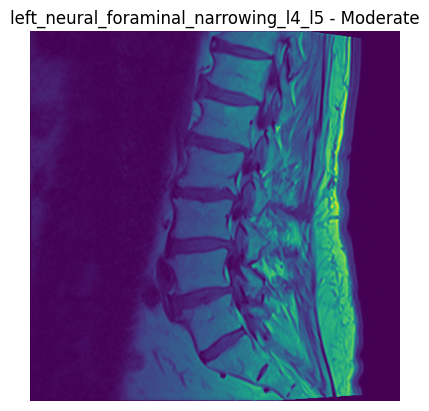

In [12]:
plt.imshow(IMG_normalized)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("left_neural_foraminal_narrowing_l4_l5 - Moderate")
plt.show()

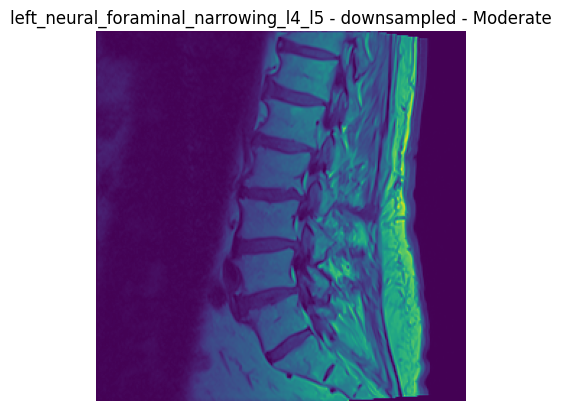

In [17]:
plt.imshow(data_downsampling)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("left_neural_foraminal_narrowing_l4_l5 - downsampled - Moderate")
plt.show()

In [6]:
full_training_data.shape

(157350, 8)

In [7]:
metadata_df_w_series_desc = dd.sql("select  t.*, ftd.series_description \
from test t \
join full_training_data ftd \
on ftd.study_id = cast(split_part(t.full_img_path,'/',-3) as int64) \
and ftd.series_id = cast(split_part(t.full_img_path,'/',-2) as int64) \
where ftd.condition_vert_level = 'left_neural_foraminal_narrowing_l4_l5' and ftd.severity is not null\
").pl()

In [9]:
metadata_df_w_series_desc.shape

(147083, 4)

In [55]:
metadata_df = metadata_df_w_series_desc.filter(pl.col('series_description')=='Sagittal T1')

In [57]:
metadata_df.shape

(33670, 4)

In [8]:
series_type_list = dd.sql("select distinct series_description from metadata_df_w_series_desc").pl().to_series().to_list()
series_type_list

['Sagittal T1', 'Sagittal T2/STIR', 'Axial T2']

In [11]:
for s_type in series_type_list:
    metadata_df = metadata_df_w_series_desc.filter(pl.col('series_description')==s_type)
    print("for images of orientation :", s_type)
    labels = []
    features = []
    for i in tqdm(range(metadata_df.shape[0])):
        dcm_image_path = metadata_df.item(i,0)
        dicom_ds = dcmread(dcm_image_path)
        img_array = dicom_ds.pixel_array
        #IMG_normalized = cv2.normalize(img_array, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        features.append(np.mean(img_array.T, axis=0))
        labels.append(metadata_df.item(i,2))
    extracted_training_features = pd.DataFrame(features, columns=['image_array'])
    extracted_training_labels = pd.DataFrame(labels, columns=['encoded_severity'])

for images of orientation : Sagittal T1


100%|██████████| 33670/33670 [11:54<00:00, 47.10it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (33670,) + inhomogeneous part.

In [14]:
features[10000].shape

(384,)

In [9]:
dd.sql("select distinct severity, encoded_severity from test order by encoded_severity").pl()

severity,encoded_severity
str,i64
"""Moderate""",0
"""Normal/Mild""",1
"""Severe""",2


### feature extraction from Image files

In [ ]:
metadata_root_path = '/kaggle/input/left-neural-foraminal-narrowing-metadata'

for file in os.listdir(metadata_root_path):
    labels = []
    features = []
    data = {}
    metadata_file_path = os.path.join(metadata_root_path, file)
    print(metadata_file_path)
    metadata_df = pl.read_csv(metadata_file_path, low_memory=True)
    for j in tqdm(range(metadata_df.shape[0])):
        dcm_image_path = metadata_df.item(j,0)
        dicom_ds = dcmread(dcm_image_path)
        img_array = dicom_ds.pixel_array
        features.append(np.mean(img_array.T, axis=0))
        labels.append(metadata_df.item(j,2))
    
    print("feature list length --> ", len(features))
    print("label list length --> ", len(labels))
    
    data["image_array"] = features
    data["encoded_severity"] = labels
    
    extracted_training_data = pd.DataFrame(data)
    
    extracted_training_data.to_csv("{0}.csv".format(file.replace('.csv','')), index=False)
        
    print('finished dumping features & labels for {0}'.format(file))

/kaggle/input/left-neural-foraminal-narrowing-metadata/left_neural_foraminal_narrowing_l4_l5_feature_metadata.csv


 26%|██▌       | 38188/147083 [16:00<33:12, 54.67it/s]  

In [33]:
type(features[100000])

numpy.ndarray

In [32]:
features[100000].shape

(448,)

In [27]:
arr_Test = np.array(features)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (147083,) + inhomogeneous part.

In [11]:
with open(file.replace('.csv',''), "wb") as file:
        pickle.dump(extracted_training_features, file)

'left_neural_foraminal_narrowing_l4_l5_feature_metadata.csv'

In [1]:
print(labels[1000])
print("feature shape -->", (round(features[1000]/255.0,5)).shape)

NameError: name 'labels' is not defined

In [ ]:
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

x = test.select(pl.col('full_img_path'))
y = test.select(pl.col('encoded_severity'))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

print("full train shape & label shape = {0} & {1}".format(x_train.shape, y_train.shape))
print("full test shape & label shape = {0} & {1}".format(x_test.shape, y_test.shape))

In [ ]:
"""dicom_ds = dcmread(dcm_image_path)
IMG = dicom_ds.pixel_array"""



In [ ]:
dd.sql("select condition_vert_level, series_description, severity, count(distinct(study_id)) as study_count \
, count(distinct(series_id)) as series_count from full_training_data \
group by condition_vert_level, series_description, severity order by 1,2,3").pl()

#### Looking at the number of studies and series of images available for various scan orientations, it appears that the Saggital orientations are missing for a couple of studies

In [ ]:
dd.sql("select series_description, count(distinct(study_id)) as studies, count(distinct(series_id)) as series \
from train_series_desc group by series_description").pl()

#### Checking whether all the different conditions for all the 5 vertebrae are available in all the studies.
#### It appears that some of the condition/vertebrae combinations are not available in some of the studies
##### e.g. The images with orientation "Axial T2" for the condition "Right Subarticular Stenosis" at the vertebra "L1/L2" is available in 1812 studies out of a total of 1975 studies

In [ ]:
part_1 = list(os.listdir('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'))
# part_1 = list(filter(lambda x: x.find('.DS') == -1, part_1))
len(part_1)

In [ ]:
meta_obj = {{ 
    'study_id': x,
    'folder_path': f"/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{x}",
    'SeriesInstanceUIDs': [] 
}
    for x in part_1 
}

In [ ]:
meta_obj

In [ ]:
"""p1 = [(x, f"/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{x}") for x in part_1]
meta_obj = { p[0]: { 'folder_path': p[1], 
                    'SeriesInstanceUIDs': [] 
                   } 
            for p in p1 }"""

In [ ]:
for m in meta_obj:
    meta_obj[m]['SeriesInstanceUIDs'] = list(os.listdir(meta_obj[m]['folder_path']))

In [ ]:
train_series_desc.filter((pl.col('study_id') == int('100206310')) & (pl.col('series_id') == int('1792451510')))\
.select(pl.col('series_description')).item(0,0)

In [ ]:
# grabs the correspoding series descriptions
for k in tqdm(meta_obj):
    for s in meta_obj[k]['SeriesInstanceUIDs']:
        if 'SeriesDescriptions' not in meta_obj[k]:
            meta_obj[k]['SeriesDescriptions'] = []
        try:
            meta_obj[k]['SeriesDescriptions'].append(train_series_desc.filter((pl.col('study_id') == int(k)) \
                                                                              & (pl.col('series_id') == int(s)))\
                                                     .select(pl.col('series_description')).item(0,0))
        except:
            print("Failed on", s, k)

In [ ]:
# ptobj = meta_obj[list(meta_obj.keys())[10]]
ptobj = meta_obj['100206310']
ptobj

In [ ]:
ptobj['image_files'] = []

for idx, i in enumerate(ptobj['SeriesInstanceUIDs']):
    print(idx)
    print(i)
    print("**********")
    ptobj['image_files'].append(glob.glob(f"{ptobj['folder_path']}/{ptobj['SeriesInstanceUIDs'][idx]}/*.dcm"))
    
#len(images)

In [ ]:
ptobj['SeriesDescriptions'][0]

In [ ]:
ptobj['image_files'][0]

In [ ]:
ptobj

In [ ]:
for k in tqdm(meta_obj):
    meta_obj[k]['image_files'] = []
    for idx, i in enumerate(meta_obj[k]['SeriesInstanceUIDs']):
        meta_obj[k]['image_files']\
        .append(len(glob.glob(f"{meta_obj[k]['folder_path']}/{meta_obj[k]['SeriesInstanceUIDs'][idx]}/*.dcm")))

In [ ]:
meta_obj['100206310']

In [ ]:
meta_obj[list(meta_obj.keys())[1]]

In [ ]:
pl.Config(fmt_str_lengths=100)
pl.Config.set_tbl_rows(1000)
dd.sql(" \
select tsd.series_description, tlc.condition, tlc.level, \
count(distinct(tlc.study_id)) as studies, count(distinct(tlc.instance_number)) as label_defining_images, \
round(count(distinct(tlc.study_id))/1975, 5) as pct_of_total_studies, \
from train_series_desc tsd \
join train_label_coordinates tlc \
on tsd.study_id = tlc.study_id \
and tsd.series_id = tlc.series_id \
group by tsd.series_description, tlc.condition, tlc.level \
order by 1,2, 4 desc \
").pl()

#### Now let's check how many studies have moderate or severe levels of the condition "Right Subarticular Stenosis" at the vertebra "L1/L2"

In [ ]:
dd.sql("select value, count(distinct(study_id)) from train_meta_data_melted where variable = 'right_subarticular_stenosis_l1_l2' \
group by value").pl()

In [ ]:
dd.sql("select value, count(distinct(study_id)) from train_meta_data_melted where variable = 'right_subarticular_stenosis_l1_l2' \
and study_id in (select distinct(study_id) from train_label_coordinates where condition = 'Right Subarticular Stenosis'\
and level = 'L1/L2') group by value").pl()

In [ ]:
train_label_coordinates_list = dd.sql("select distinct study_id from train_meta_data_melted where variable = 'right_subarticular_stenosis_l1_l2' \
and value = 'Normal/Mild' \
and study_id in (select distinct(study_id) from train_label_coordinates where condition = 'Right Subarticular Stenosis'\
and level = 'L1/L2')").pl().to_series().unique().to_list()

train_meta_data_list = dd.sql("select distinct study_id from train_meta_data_melted where variable = 'right_subarticular_stenosis_l1_l2' and value = 'Normal/Mild' ")\
.pl().to_series().unique().to_list()

set(train_label_coordinates_list) ^ set(train_meta_data_list)

#### The above analysis shows that there are two studies related to Right Subarticular Stenosis of L1/L2 which are not present in the train_label_coordinates file

In [ ]:
dd.sql("select * from train_label_coordinates where study_id in ('3008676218','3303545110')").pl()

In [ ]:
dd.sql("select * from train_meta_data where study_id in ('3008676218','3303545110')").pl().transpose(include_header=True)

#### It seems from above, that the study 3303545110 is only present for Right Subarticular Stenosis of L5/S1 and not of L1/L2 and the study 3008676218 is not present at all for any conditions/vertebrae combination
#### The questions is then how is 3303545110 labelled as Normal/Mild for Right Subarticular Stenosis of L1/L2 and 3008676218 labelled for all the conditions/vertebrae combination

#### Below are some of the images from the study_id/patient 100206310 

In [ ]:
dcm_image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1012284084/20.dcm'
left_centre_coords = (int(180.355677), int(165.0342))
right_centre_coords = (int(145.120536), int(162.285714))
radius = 10
color = (255, 0, 0)  # Red color in BGR
thickness = 2

dicom_ds = dcmread(dcm_image_path)
IMG = dicom_ds.pixel_array

IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

left_IMG_with_circle = cv2.circle(IMG_normalized.copy(), left_centre_coords, radius, color, thickness)
left_IMG_with_circle = cv2.cvtColor(left_IMG_with_circle, cv2.COLOR_BGR2RGB)

right_IMG_with_circle = cv2.circle(IMG_normalized.copy(), right_centre_coords, radius, color, thickness)
right_IMG_with_circle = cv2.cvtColor(right_IMG_with_circle, cv2.COLOR_BGR2RGB)

In [ ]:
IMG.shape

In [ ]:
plt.imshow(left_IMG_with_circle)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Left subarticular stenosis L1/L2 - Normal/Mild")
plt.show()

In [ ]:
plt.imshow(right_IMG_with_circle)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Right subarticular stenosis L1/L2 - Normal/Mild")
plt.show()

In [ ]:
dcm_image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1012284084/46.dcm'
left_centre_coords = (int(168.536252), int(156.27907))
right_centre_coords = (int(146.263393), int(160.0))
radius = 10
color = (255, 0, 0)  # Red color in BGR
thickness = 2

dicom_ds = dcmread(dcm_image_path)
IMG = dicom_ds.pixel_array

IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

left_IMG_with_circle = cv2.circle(IMG_normalized.copy(), left_centre_coords, radius, color, thickness)
left_IMG_with_circle = cv2.cvtColor(left_IMG_with_circle, cv2.COLOR_BGR2RGB)

right_IMG_with_circle = cv2.circle(IMG_normalized.copy(), right_centre_coords, radius, color, thickness)
right_IMG_with_circle = cv2.cvtColor(right_IMG_with_circle, cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(left_IMG_with_circle)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Left subarticular stenosis L4/L5 - Severe")
plt.show()

In [ ]:
plt.imshow(right_IMG_with_circle)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Right subarticular stenosis L4/L5 - Moderate")
plt.show()

In [ ]:
dcm_image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/2092806862/4.dcm'
right_centre_coords = (int(253.393075), int(278.680244))
radius = 10
color = (255, 0, 0)  # Red color in BGR
thickness = 2

dicom_ds = dcmread(dcm_image_path)
IMG = dicom_ds.pixel_array

IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

right_IMG_with_circle = cv2.circle(IMG_normalized.copy(), right_centre_coords, radius, color, thickness)
right_IMG_with_circle = cv2.cvtColor(right_IMG_with_circle, cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(right_IMG_with_circle)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Right neural foraminal narrowing L4/L5 - Moderate")
plt.show()

## Aim : To select image files to create Train and Validation set
1. 25% of data will be set aside permanently as a validation set for all experiments. This set won't be used for training/testing/cross-validation
2. 75% of data will be used for all experiments
3. Images are 320 * 320 arrays
### Modelling strategy
1. Build 25 different models, one per condition/vertebrae combination

#### Pipeline to make a sample submission to test the submission data creation logic

In [ ]:
submission = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/sample_submission.csv')
submission['row_id'] = 'samples'

In [ ]:
import glob
import os

config = {}
config['root_file_path'] = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'

studies = os.listdir(config['root_file_path'])

In [ ]:
studies

In [ ]:
rows = {}
weight_dict = {'normal_mild':1, 'moderate':2, 'severe':4}
conditions = ['spinal_canal_stenosis', 'neural_foraminal_narrowing', 'subarticular_stenosis']
sides = ['left', 'right']
vertebrae_levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']
severity_levels = ['normal_mild', 'moderate', 'severe']

for c in conditions:
    for v in vertebrae_levels:
        if c != 'spinal_canal_stenosis':
            for s in sides:
                for st in studies:
                    #print(st+'_'+s+'_'+c+'_'+v)
                    rows[st+'_'+s+'_'+c+'_'+v] = np.array([0.333333 * 2, 0.333333 * 2, 0.333333 * 2])
        else:
            for st in studies:
                #print(st+'_'+c+'_'+v)
                rows[st+'_'+c+'_'+v] = np.array([0.333333 * 2, 0.333333 * 2, 0.333333 * 2])

In [ ]:
for row_id, feature in tqdm(rows.items()):
    feature_set_reshaped = feature.reshape(1, -1)
    predictions = np.ascontiguousarray(feature_set_reshaped/2)
    df = pd.DataFrame(predictions, columns=severity_levels)
    df.insert(loc=0, column='row_id', value=row_id)
    submission = pd.concat([submission,df]).reset_index(drop=True)
    
i = submission[(submission.row_id == 'samples')].index
submission = submission.drop(i).reset_index(drop=True)

In [ ]:
submission.to_csv('submission.csv', index=False)